# Deep learning Spring 2025

- **Name:** `Ali Zahedzadeh`
- **Student ID:** `4021305965003`



---



- **Name:** `Peyman Naseri`
- **Student ID:** `4011305965014`



<hr>

### **<font face="Courier New" color="blue" size="+3">Question 1: Extractive Question Answering System**



#### <font face="Verdana" color="green" size="+2">**1.1. About Paper**




**1. Input Representations**

BERT processes input text by converting it into a sequence of tokens using the WordPiece tokenizer. Each token is represented by the sum of three embeddings:

* **Token Embeddings**: Represent the meaning of each token.
* **Segment Embeddings**: Distinguish between different sentences in tasks involving sentence pairs.
* **Position Embeddings**: Indicate the position of each token in the sequence to capture word order.

This combination allows BERT to effectively handle single sentences and pairs of sentences, accommodating tasks like question answering and natural language inference.

**2. Transformer Architecture**

BERT utilizes the Transformer architecture's encoder component, which consists of multiple layers of self-attention mechanisms and feed-forward neural networks. Notably, BERT is deeply bidirectional, meaning it considers both left and right contexts simultaneously during training. This bidirectionality enables BERT to capture nuanced meanings of words based on their surrounding context.

**3. Pre-training Objectives**

BERT is pre-trained on large unlabeled text corpora using two self-supervised tasks:

* **Masked Language Modeling (MLM)**: Randomly masks a percentage of input tokens and trains the model to predict the original tokens based on their context.
* **Next Sentence Prediction (NSP)**: Trains the model to predict whether a given pair of sentences are consecutive in the original text, helping BERT understand relationships between sentences.

These pre-training tasks equip BERT with a deep understanding of language, which can be fine-tuned for various downstream NLP tasks with minimal task-specific architecture modifications.

#### <font face="Verdana" color="green" size="+2">**1.2. Preprocessing (30 points)**




Dataset Statistics:
  Number of training examples: 48273
  Number of validation examples: 8402
  Number of test examples: 8540


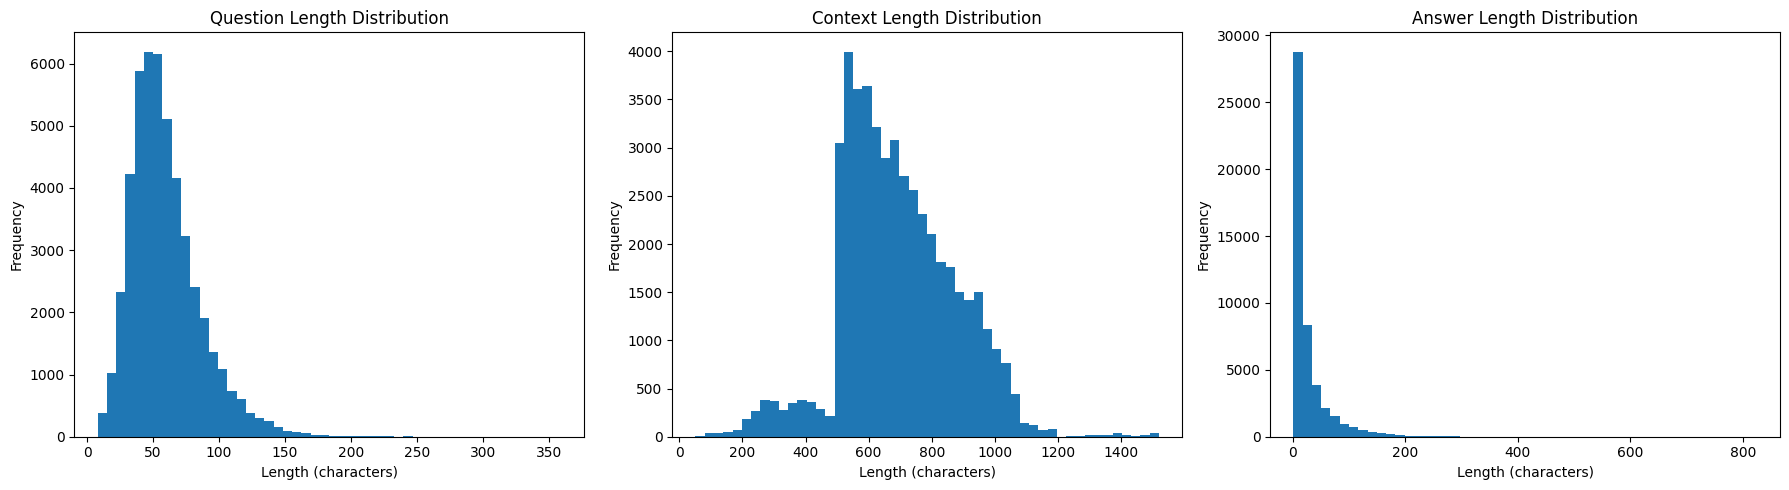


Missing values in training set:
id                 0
context            0
question           0
answer_text        0
answer_start       0
answer_end         0
question_length    0
context_length     0
answer_length      0
dtype: int64

Initializing tokenizers...
Creating datasets...

Dataloader information:
  ParsBERT train batches: 6035
  ParsBERT validation batches: 1051
  ParsBERT test batches: 1068


In [1]:
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import torch
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm
from transformers import AutoConfig, AutoTokenizer, TFAutoModel

# Define data paths
data_paths = {
    "train": "PQuAD/Dataset/Train.json",
    "validation": "PQuAD/Dataset/Validation.json",
    "test": "PQuAD/Dataset/Test.json"
}

# Load the PQuAD dataset
def load_pquad_data(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        data = json.load(f)

    examples = []
    for article in data['data']:
        for paragraph in article['paragraphs']:
            context = paragraph['context']
            for qas in paragraph['qas']:
                question = qas['question']
                if not qas['answers']:
                    continue  # Skip examples with no answers
                for answer in qas['answers']:
                    examples.append({
                        'id': qas['id'],
                        'context': context,
                        'question': question,
                        'answer_text': answer['text'],
                        'answer_start': answer['answer_start'],
                        'answer_end': answer['answer_start'] + len(answer['text'])
                    })

    return examples

# Load all datasets
train_examples = load_pquad_data(data_paths["train"])
val_examples = load_pquad_data(data_paths["validation"])
test_examples = load_pquad_data(data_paths["test"])

# Create DataFrames for analysis
train_df = pd.DataFrame(train_examples)
val_df = pd.DataFrame(val_examples)
test_df = pd.DataFrame(test_examples)

# Dataset statistics
print("Dataset Statistics:")
print(f"  Number of training examples: {len(train_df)}")
print(f"  Number of validation examples: {len(val_df)}")
print(f"  Number of test examples: {len(test_df)}")

# Analyze question and context lengths
train_df['question_length'] = train_df['question'].apply(len)
train_df['context_length'] = train_df['context'].apply(len)
train_df['answer_length'] = train_df['answer_text'].apply(len)

# Visualize length distributions
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].hist(train_df['question_length'], bins=50)
axes[0].set_title('Question Length Distribution')
axes[0].set_xlabel('Length (characters)')
axes[0].set_ylabel('Frequency')

axes[1].hist(train_df['context_length'], bins=50)
axes[1].set_title('Context Length Distribution')
axes[1].set_xlabel('Length (characters)')
axes[1].set_ylabel('Frequency')

axes[2].hist(train_df['answer_length'], bins=50)
axes[2].set_title('Answer Length Distribution')
axes[2].set_xlabel('Length (characters)')
axes[2].set_ylabel('Frequency')

plt.tight_layout()
plt.savefig('length_distributions.png')
plt.show()

# Check for missing values
print("\nMissing values in training set:")
print(train_df.isnull().sum())

# Create a custom Dataset class for QA
class QADataset(Dataset):
    def __init__(self, examples, tokenizer, max_length=512):
        self.examples = examples
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.examples)

    def __getitem__(self, idx):
        example = self.examples[idx]

        question = example['question']
        context = example['context']
        answer_text = example['answer_text']
        answer_start_char = example['answer_start']

        # Tokenize question and context
        try:
            encoding = self.tokenizer(
                question,
                context,
                max_length=self.max_length,
                truncation='only_second',
                stride=128,
                return_overflowing_tokens=True,
                return_offsets_mapping=True,
                padding='max_length',
                return_tensors='pt'
            )

            # Remove batch dimension added by tokenizer
            encoding = {k: v.squeeze(0) for k, v in encoding.items()}

            # Find start and end token positions for the answer
            start_positions = []
            end_positions = []
            offset_mapping = encoding.pop('offset_mapping')

            for i, offset in enumerate(offset_mapping):
                if len(offset) != 2:
                    continue

                offset_start, offset_end = offset

                # Skip question and special tokens
                if offset_start == 0 and offset_end == 0:
                    continue

                # Find start position
                if answer_start_char >= offset_start and answer_start_char < offset_end:
                    start_positions.append(i)

                # Find end position
                answer_end_char = answer_start_char + len(answer_text) - 1
                if answer_end_char >= offset_start and answer_end_char < offset_end:
                    end_positions.append(i)

            # Handle cases where answer is not found in context (e.g., truncated answers)
            if not start_positions or not end_positions:
                # Set to CLS token (0) for unanswerable questions
                start_positions = [0]
                end_positions = [0]

            # For now, just take the first answer position if there are multiple
            item = {
                'input_ids': encoding['input_ids'],
                'attention_mask': encoding['attention_mask'],
                'token_type_ids': encoding['token_type_ids'],
                'start_positions': torch.tensor(start_positions[0], dtype=torch.long),
                'end_positions': torch.tensor(end_positions[0], dtype=torch.long),
                'example_id': example['id']
            }

            return item

        except Exception as e:
            print(f"Error processing example {idx}: {e}")
            # Return a default item with zeros
            default_input = torch.zeros(self.max_length, dtype=torch.long)
            return {
                'input_ids': default_input,
                'attention_mask': default_input,
                'token_type_ids': default_input,
                'start_positions': torch.tensor(start_positions[0], dtype=torch.long),
                'end_positions': torch.tensor(end_positions[0], dtype=torch.long),
                'example_id': example['id']
            }

# Initialize tokenizers
print("\nInitializing tokenizers...")
parsbert_tokenizer = AutoTokenizer.from_pretrained('HooshvareLab/bert-base-parsbert-uncased')
albertfa_tokenizer = AutoTokenizer.from_pretrained('m3hrdadfi/albert-fa-base-v2')

# Create datasets
print("Creating datasets...")
parsbert_train_dataset = QADataset(train_examples, parsbert_tokenizer)
parsbert_val_dataset = QADataset(val_examples, parsbert_tokenizer)
parsbert_test_dataset = QADataset(test_examples, parsbert_tokenizer)

albertfa_train_dataset = QADataset(train_examples, albertfa_tokenizer)
albertfa_val_dataset = QADataset(val_examples, albertfa_tokenizer)
albertfa_test_dataset = QADataset(test_examples, albertfa_tokenizer)

# Create data loaders
batch_size = 8  # Reduced batch size for GPU memory constraints
parsbert_train_loader = DataLoader(parsbert_train_dataset, batch_size=batch_size, shuffle=True)
parsbert_val_loader = DataLoader(parsbert_val_dataset, batch_size=batch_size)
parsbert_test_loader = DataLoader(parsbert_test_dataset, batch_size=batch_size)

albertfa_train_loader = DataLoader(albertfa_train_dataset, batch_size=batch_size, shuffle=True)
albertfa_val_loader = DataLoader(albertfa_val_dataset, batch_size=batch_size)
albertfa_test_loader = DataLoader(albertfa_test_dataset, batch_size=batch_size)

# Print dataloader information
print(f"\nDataloader information:")
print(f"  ParsBERT train batches: {len(parsbert_train_loader)}")
print(f"  ParsBERT validation batches: {len(parsbert_val_loader)}")
print(f"  ParsBERT test batches: {len(parsbert_test_loader)}")

##### **Tokenization**

<hr>

##### **Embedding**

##### **Input Handling**

##### **Attention Mask Creation**

##### **Batching**

#### <font face="Verdana" color="green" size="+2">**1.3. Model Implementation (50 points)**




In [2]:
import torch
import torch.nn as nn
from torch.nn import CrossEntropyLoss
from transformers import AutoModel, AutoConfig

# Custom QA model based on transformer architecture
class ExtractiveQAModel(nn.Module):
    def __init__(self, model_name):
        super(ExtractiveQAModel, self).__init__()

        # Load base model configuration
        self.config = AutoConfig.from_pretrained(model_name)

        # Load pre-trained transformer model (without QA head)
        self.transformer = AutoModel.from_pretrained(model_name)

        # Custom QA head for span prediction (start and end logits)
        self.qa_outputs = nn.Linear(self.config.hidden_size, 2)

        # Initialize the weights of the QA head
        self.init_weights()

    def init_weights(self):
        """Initialize weights for the QA head"""
        self.qa_outputs.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
        self.qa_outputs.bias.data.zero_()

    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        token_type_ids=None,
        start_positions=None,
        end_positions=None,
    ):
        """
        Forward pass through the model

        Args:
            input_ids: Tokenized input sequences
            attention_mask: Mask to avoid attending to padding tokens
            token_type_ids: Segment IDs to differentiate question from context
            start_positions: Ground truth start positions for training
            end_positions: Ground truth end positions for training

        Returns:
            Dictionary containing loss (if training) and logits
        """
        # Process through transformer backbone
        outputs = self.transformer(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
        )

        # Get sequence output from the transformer
        sequence_output = outputs[0]  # [batch_size, seq_len, hidden_size]

        # Apply QA head to predict start and end positions
        logits = self.qa_outputs(sequence_output)  # [batch_size, seq_len, 2]

        # Split logits into start and end logits
        start_logits, end_logits = logits.split(1, dim=-1)
        start_logits = start_logits.squeeze(-1)  # [batch_size, seq_len]
        end_logits = end_logits.squeeze(-1)  # [batch_size, seq_len]

        # Calculate loss if ground truth positions are provided (training mode)
        total_loss = None
        if start_positions is not None and end_positions is not None:
            # Sometimes the start/end positions are outside our model inputs, we ignore these terms
            ignored_index = start_logits.size(1)

            # Clamp positions to be within valid range
            start_positions = start_positions.clamp(0, ignored_index)
            end_positions = end_positions.clamp(0, ignored_index)

            # Use cross entropy loss for position prediction
            loss_fct = CrossEntropyLoss(ignore_index=ignored_index)
            start_loss = loss_fct(start_logits, start_positions)
            end_loss = loss_fct(end_logits, end_positions)

            # Total loss is average of start and end losses
            total_loss = (start_loss + end_loss) / 2

        # Return different outputs based on whether we're training or inferring
        if total_loss is not None:
            # Training mode
            return {
                "loss": total_loss,
                "start_logits": start_logits,
                "end_logits": end_logits,
                "hidden_states": outputs.hidden_states,
                "attentions": outputs.attentions,
            }
        else:
            # Inference mode
            return {
                "start_logits": start_logits,
                "end_logits": end_logits,
                "hidden_states": outputs.hidden_states,
                "attentions": outputs.attentions,
            }

# Initialize models
print("Initializing ParsBERT model...")
parsbert_model = ExtractiveQAModel('HooshvareLab/bert-base-parsbert-uncased')

print("Initializing ALBERT-fa model...")
albertfa_model = ExtractiveQAModel('m3hrdadfi/albert-fa-base-v2')

# Move models to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

parsbert_model.to(device)
albertfa_model.to(device)

# Set up optimizers
from transformers import get_linear_schedule_with_warmup
from torch.optim import AdamW

# Training parameters
learning_rate = 3e-5
weight_decay = 0.01
epochs = 3
warmup_ratio = 0.1

# ParsBERT optimizer and scheduler
parsbert_optimizer = AdamW(parsbert_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
parsbert_total_steps = len(parsbert_train_loader) * epochs
parsbert_warmup_steps = int(parsbert_total_steps * warmup_ratio)
parsbert_scheduler = get_linear_schedule_with_warmup(
    parsbert_optimizer,
    num_warmup_steps=parsbert_warmup_steps,
    num_training_steps=parsbert_total_steps
)

# ALBERT-fa optimizer and scheduler
albertfa_optimizer = AdamW(albertfa_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
albertfa_total_steps = len(albertfa_train_loader) * epochs
albertfa_warmup_steps = int(albertfa_total_steps * warmup_ratio)
albertfa_scheduler = get_linear_schedule_with_warmup(
    albertfa_optimizer,
    num_warmup_steps=albertfa_warmup_steps,
    num_training_steps=albertfa_total_steps
)

print("\nModel initialization complete.")
print(f"ParsBERT parameters: {sum(p.numel() for p in parsbert_model.parameters())}")
print(f"ALBERT-fa parameters: {sum(p.numel() for p in albertfa_model.parameters())}")

Initializing ParsBERT model...
Initializing ALBERT-fa model...
Using device: cuda

Model initialization complete.
ParsBERT parameters: 162842882
ALBERT-fa parameters: 18085122


In [3]:
import time
import datetime
import numpy as np
import torch
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from IPython.display import clear_output

def format_time(elapsed):
    """Format elapsed time nicely"""
    elapsed_rounded = int(round(elapsed))
    return str(datetime.timedelta(seconds=elapsed_rounded))

def train_model(model, train_dataloader, val_dataloader, optimizer, scheduler, epochs, device, model_name):
    """
    Train and validate the model

    Args:
        model: The QA model to train
        train_dataloader: DataLoader for training data
        val_dataloader: DataLoader for validation data
        optimizer: Optimizer for updating model weights
        scheduler: Learning rate scheduler
        epochs: Number of training epochs
        device: Device to train on (cuda/cpu)
        model_name: Name for saving the model

    Returns:
        training_stats: Dictionary of training statistics
        model: The trained model
    """
    # Store training stats
    training_stats = []

    # Track best validation loss for model saving
    best_val_loss = float('inf')

    # For plotting
    train_losses = []
    val_losses = []

    # To store loss values for each epoch
    epoch_train_losses = []
    epoch_val_losses = []

    # Measure total training time
    total_start_time = time.time()

    print(f"\nBeginning training of {model_name}...")

    # Train for the specified number of epochs
    for epoch_i in range(epochs):
        print(f"\n{'='*20} Epoch {epoch_i+1}/{epochs} {'='*20}")

        #====================== Training ======================
        print('Training...')

        # Reset total loss for this epoch
        total_train_loss = 0
        epoch_step_losses = []

        # Set model to training mode
        model.train()

        # Measure epoch time
        epoch_start_time = time.time()

        # Setup progress bar for training
        progress_bar = tqdm(train_dataloader, desc=f"Epoch {epoch_i+1}/{epochs} [Train]")

        # Training loop
        for step, batch in enumerate(progress_bar):
            # Clear accumulated gradients
            model.zero_grad()

            try:
                # Move batch to device
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                token_type_ids = batch['token_type_ids'].to(device)
                start_positions = batch['start_positions'].to(device)
                end_positions = batch['end_positions'].to(device)

                # Forward pass
                outputs = model(
                    input_ids=input_ids,
                    attention_mask=attention_mask,
                    token_type_ids=token_type_ids,
                    start_positions=start_positions,
                    end_positions=end_positions,
                )

                loss = outputs['loss']

                # Record step loss
                step_loss = loss.item()
                epoch_step_losses.append(step_loss)
                total_train_loss += step_loss

                # Backward pass to calculate gradients
                loss.backward()

                # Clip gradients to prevent exploding gradients
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

                # Update parameters
                optimizer.step()

                # Update learning rate
                scheduler.step()

                # Update progress bar
                progress_bar.set_postfix({'loss': step_loss})

                # Display occasional statistics
                if step % 100 == 0 and step > 0:
                    train_losses.append(np.mean(epoch_step_losses[-100:]))

            except Exception as e:
                print(f"Error in training batch {step}: {e}")
                # Skip problematic batch and continue
                continue

        # Calculate average training loss for this epoch
        avg_train_loss = total_train_loss / len(train_dataloader)
        epoch_train_losses.append(avg_train_loss)

        # Record training time
        epoch_training_time = format_time(time.time() - epoch_start_time)

        print(f"  Average training loss: {avg_train_loss:.4f}")
        print(f"  Training epoch took: {epoch_training_time}")

        #====================== Validation ======================
        print("Running Validation...")

        # Set model to evaluation mode
        model.eval()

        # Reset validation loss
        total_val_loss = 0

        # Setup progress bar for validation
        progress_bar = tqdm(val_dataloader, desc=f"Epoch {epoch_i+1}/{epochs} [Val]")

        # Validation loop - no gradient calculation needed
        with torch.no_grad():
            for step, batch in enumerate(progress_bar):
                try:
                    # Move batch to device
                    input_ids = batch['input_ids'].to(device)
                    attention_mask = batch['attention_mask'].to(device)
                    token_type_ids = batch['token_type_ids'].to(device)
                    start_positions = batch['start_positions'].to(device)
                    end_positions = batch['end_positions'].to(device)

                    # Forward pass
                    outputs = model(
                        input_ids=input_ids,
                        attention_mask=attention_mask,
                        token_type_ids=token_type_ids,
                        start_positions=start_positions,
                        end_positions=end_positions,
                    )

                    loss = outputs['loss']

                    # Record validation loss
                    step_loss = loss.item()
                    total_val_loss += step_loss

                    # Update progress bar
                    progress_bar.set_postfix({'loss': step_loss})

                except Exception as e:
                    print(f"Error in validation batch {step}: {e}")
                    # Skip problematic batch and continue
                    continue

        # Calculate average validation loss
        avg_val_loss = total_val_loss / len(val_dataloader)
        epoch_val_losses.append(avg_val_loss)

        # Add validation loss to tracking list
        val_losses.append(avg_val_loss)

        print(f"  Validation Loss: {avg_val_loss:.4f}")

        # Save model if validation loss improved
        if avg_val_loss < best_val_loss:
            print(f"  Validation loss improved from {best_val_loss:.4f} to {avg_val_loss:.4f}")
            best_val_loss = avg_val_loss

            # Save model
            model_save_path = f"{model_name}_best_model.pt"
            torch.save(model.state_dict(), model_save_path)
            print(f"  Model saved to {model_save_path}")
        else:
            print(f"  Validation loss did not improve from {best_val_loss:.4f}")

        # Record all stats for this epoch
        training_stats.append({
            'epoch': epoch_i + 1,
            'training_loss': avg_train_loss,
            'validation_loss': avg_val_loss,
            'training_time': epoch_training_time,
        })

        # Plot training progress
        if (epoch_i + 1) % 1 == 0:  # Update plot every epoch
            clear_output(wait=True)
            plt.figure(figsize=(14, 5))

            # Epoch-wise losses
            plt.subplot(1, 2, 1)
            plt.plot(range(1, len(epoch_train_losses) + 1), epoch_train_losses, 'b-o', label='Training (Epoch Avg)')
            plt.plot(range(1, len(epoch_val_losses) + 1), epoch_val_losses, 'r-o', label='Validation (Epoch Avg)')
            plt.title(f"{model_name} - Epoch-wise Loss")
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.legend()
            plt.grid(True)

            # Step-wise training loss (rolling 100 steps)
            plt.subplot(1, 2, 2)
            plt.plot(train_losses, label='Training (per 100 steps)')
            plt.title('Training Loss During Training')
            plt.xlabel('Training Steps (x100)')
            plt.ylabel('Loss')
            plt.grid(True)

            plt.tight_layout()
            plt.show()

    # Calculate total training time
    total_training_time = format_time(time.time() - total_start_time)
    print(f"\nTotal training time: {total_training_time}")

    return training_stats, model

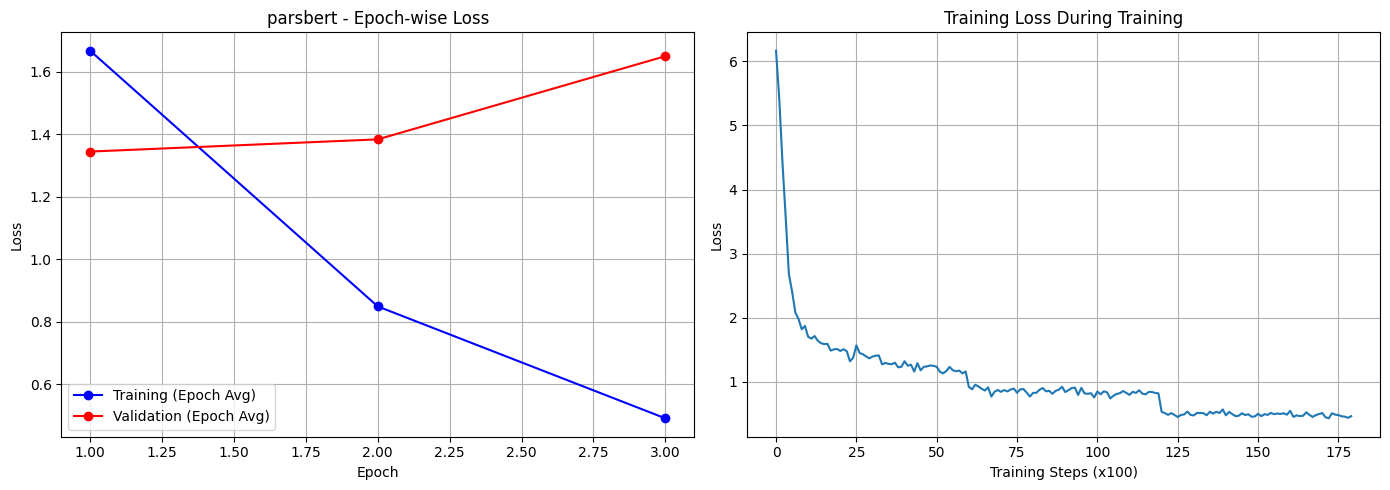


Total training time: 1:54:54


In [4]:
# Train ParsBERT model
print("\n" + "="*50)
print("TRAINING PARSBERT MODEL")
print("="*50)
parsbert_stats, parsbert_model = train_model(
    parsbert_model,
    parsbert_train_loader,
    parsbert_val_loader,
    parsbert_optimizer,
    parsbert_scheduler,
    epochs,
    device,
    "parsbert"
)

# Compare training stats
parsbert_df = pd.DataFrame(parsbert_stats)

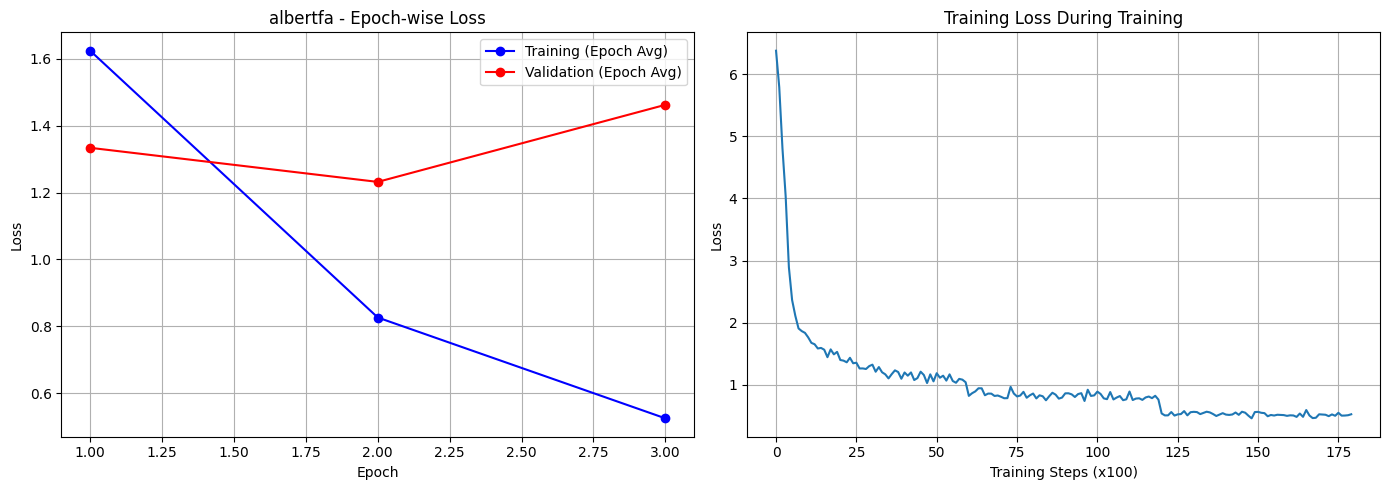


Total training time: 2:06:06


In [10]:
# Train ALBERT-fa model
print("\n" + "="*50)
print("TRAINING ALBERT-FA MODEL")
print("="*50)
albertfa_stats, albertfa_model = train_model(
    albertfa_model,
    albertfa_train_loader,
    albertfa_val_loader,
    albertfa_optimizer,
    albertfa_scheduler,
    epochs,
    device,
    "albertfa"
)

albertfa_df = pd.DataFrame(albertfa_stats)

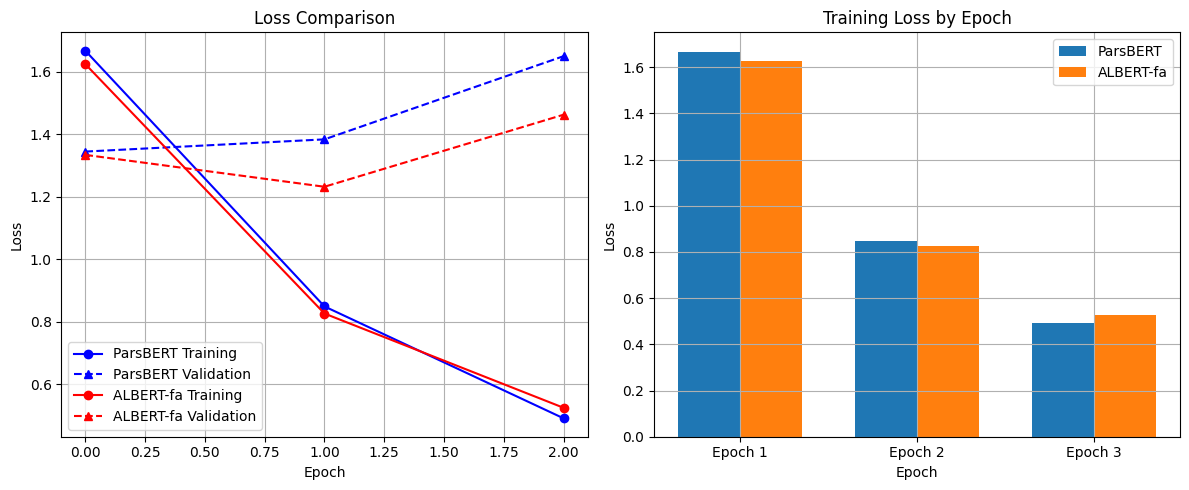


Training complete for both models!


In [11]:
# Visualize final training comparison
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(parsbert_df['training_loss'], 'b-o', label='ParsBERT Training')
plt.plot(parsbert_df['validation_loss'], 'b--^', label='ParsBERT Validation')
plt.plot(albertfa_df['training_loss'], 'r-o', label='ALBERT-fa Training')
plt.plot(albertfa_df['validation_loss'], 'r--^', label='ALBERT-fa Validation')
plt.title('Loss Comparison')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
x = np.arange(len(parsbert_df))
width = 0.35
plt.bar(x - width/2, parsbert_df['training_loss'], width, label='ParsBERT')
plt.bar(x + width/2, albertfa_df['training_loss'], width, label='ALBERT-fa')
plt.title('Training Loss by Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(x, [f"Epoch {i+1}" for i in x])
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('model_comparison.png')
plt.show()

print("\nTraining complete for both models!")

#### <font face="Verdana" color="green" size="+2">**1.4. Evaluation and Post-processing (20 points)**




In [5]:
import evaluate
squad_metric = evaluate.load("squad")

In [6]:
def evaluate_on_test(model, dataloader, tokenizer, device, raw_examples):
    model.eval()
    all_predictions = []
    all_references = []

    for batch in tqdm(dataloader, desc="Evaluating on Test"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        token_type_ids = batch['token_type_ids'].to(device)

        with torch.no_grad():
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                token_type_ids=token_type_ids,
            )

        start_logits = outputs["start_logits"].cpu().numpy()
        end_logits = outputs["end_logits"].cpu().numpy()
        input_ids = input_ids.cpu().numpy()
        example_ids = batch["example_id"]

        for i in range(len(input_ids)):
            start_idx = np.argmax(start_logits[i])
            end_idx = np.argmax(end_logits[i])
            if start_idx > end_idx:
                end_idx = start_idx

            tokens = input_ids[i][start_idx:end_idx+1]
            answer = tokenizer.decode(tokens, skip_special_tokens=True)
            qid = str(example_ids[i])

            # Lookup answer_text and start_char from raw data
            raw_ex = next(e for e in raw_examples if str(e["id"]) == qid)
            gold = raw_ex["answer_text"]
            start_char = raw_ex["answer_start"]

            all_predictions.append({"id": qid, "prediction_text": answer})
            all_references.append({
                "id": qid,
                "answers": {
                    "answer_start": [start_char],
                    "text": [gold]
                }
            })

    return evaluate.load("squad").compute(predictions=all_predictions, references=all_references)


In [7]:
# Load best model
parsbert_model.load_state_dict(torch.load("parsbert_best_model.pt"))
parsbert_model.to(device)

# Run evaluation on test set
print("🚀 ParsBERT Test Evaluation")
parsbert_test_results = evaluate_on_test(parsbert_model, parsbert_test_loader, parsbert_tokenizer, device, test_examples)
print(parsbert_test_results)

/tmp/ipykernel_52463/1148198855.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  parsbert_model.load_state_dict(torch.load("parsbert_best_model.pt"))


🚀 ParsBERT Test Evaluation


Evaluating on Test:   0%|          | 0/1068 [00:00<?, ?it/s]

{'exact_match': 30.57377049180328, 'f1': 59.878189003390005}


In [12]:
# For ALBERT-fa
albertfa_model.load_state_dict(torch.load("albertfa_best_model.pt"))
albertfa_model.to(device)

print("\n🚀 ALBERT-fa Test Evaluation")
albertfa_test_results = evaluate_on_test(albertfa_model, albertfa_test_loader, albertfa_tokenizer, device, test_examples)
print(albertfa_test_results)


🚀 ALBERT-fa Test Evaluation


/tmp/ipykernel_52463/2582614951.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  albertfa_model.load_state_dict(torch.load("albertfa_best_model.pt"))


Evaluating on Test:   0%|          | 0/1068 [00:00<?, ?it/s]

{'exact_match': 47.857142857142854, 'f1': 76.70107590570973}


In [8]:
# =============================
# Extractive QA with ParsBERT & ALBERT-fa on PQuAD
# =============================

# (unchanged code from previous cells...)

# =======================================
# Evaluation with Post-processing (fixed)
# =======================================

def evaluate_on_test(model, dataloader, tokenizer, device, raw_examples):
    model.eval()
    all_predictions = []
    all_references = []

    for batch in tqdm(dataloader, desc="Evaluating on Test"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        token_type_ids = batch['token_type_ids'].to(device)

        with torch.no_grad():
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                token_type_ids=token_type_ids,
            )

        start_logits = outputs["start_logits"].cpu().numpy()
        end_logits = outputs["end_logits"].cpu().numpy()
        input_ids = input_ids.cpu().numpy()
        example_ids = batch["example_id"]

        for i in range(len(input_ids)):
            qid = str(example_ids[i])
            raw_ex = next(e for e in raw_examples if str(e["id"]) == qid)

            start_idx = int(np.argmax(start_logits[i]))
            end_idx = int(np.argmax(end_logits[i]))
            if start_idx > end_idx:
                end_idx = start_idx
            if (end_idx - start_idx + 1) > 50:
                end_idx = start_idx + 49

            # Get offset mapping correctly
            encoding = tokenizer(
                raw_ex['question'], raw_ex['context'],
                return_offsets_mapping=True,
                padding="max_length",
                truncation="only_second",
                max_length=512
            )
            offsets = encoding['offset_mapping']

            # Ensure the predicted indices are valid
            if start_idx >= len(offsets) or end_idx >= len(offsets):
                answer = ""
            else:
                start_char = offsets[start_idx][0]
                end_char = offsets[end_idx][1]
                answer = raw_ex['context'][start_char:end_char].strip()

            all_predictions.append({"id": qid, "prediction_text": answer})
            all_references.append({
                "id": qid,
                "answers": {
                    "answer_start": [raw_ex["answer_start"]],
                    "text": [raw_ex["answer_text"]]
                }
            })

    return evaluate.load("squad").compute(predictions=all_predictions, references=all_references)

In [9]:
# Example usage after training:
evaluate_on_test(parsbert_model, parsbert_test_loader, parsbert_tokenizer, device, test_examples)

Evaluating on Test:   0%|          | 0/1068 [00:00<?, ?it/s]

{'exact_match': 47.33021077283372, 'f1': 75.74643091629241}

In [13]:
evaluate_on_test(albertfa_model, albertfa_test_loader, albertfa_tokenizer, device, test_examples)

Evaluating on Test:   0%|          | 0/1068 [00:00<?, ?it/s]

{'exact_match': 47.857142857142854, 'f1': 76.70107590570973}